Below are the packages I've used in this analysis. Also, be warned, the 4th chunk took me a couple of minutes to run! You can speed it up by reducing the size of the random sample of movies (I used 200). Hopefully it won't break anything.

In [2]:
import requests
import random
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from bs4 import BeautifulSoup

The first thing we need to do is get a list of all of the available film names to iterate over.

In [3]:
# this code just downloads all of the code from the contents page and then prints all of
# the titles one by one - each movie is stored in a <"p"> object so I just want to find 
# these and store them in an object I can iterate over.

index_page = requests.get("https://www.imsdb.com/all%20scripts/")
index_page_content = BeautifulSoup(index_page.content, "html.parser")
movie_title_list = index_page_content.find_all("p")

print(str(len(movie_title_list))+" movie titles have been retrieved.")

1210 movie titles have been retrieved.


So iterating over this entire list would be an issue because it would take forever. Instead we're just going to take a random sample of 200 movie titles and analyse those scripts instead.

In [5]:
movie_title_list_sub = random.sample(movie_title_list, 200)

Almost all of the URLs for the pages with the scripts on have this format: https://www.imsdb.com/scripts/Black-Panther.html. The base URL is https://www.imsdb.com/scripts/, which is followed by the title of the movie with dashes in between each word. There are a few that are a little different (it's inconsistent about which punctuation is kept) but we can cross that bridge when we get to it. For now, we just want to replace all of the spaces (and colons) in the movie title list with dashes, and automatically generate the URLs from it.

I'm going to store the film scripts as a dictonary so I can access the scripts by their title.

In [6]:
movie_dictionary = {}

for movie in movie_title_list_sub:
    
    # the movie titles are stored in these <"a"> structures, so I want to find them
    # and put them into the correct format for a URL.
    
    movie_title = movie.find("a")
    movie_title_URL = movie_title.text.replace(" ", "-").replace(":","")
    script_URL = "https://www.imsdb.com/scripts/"+movie_title_URL+".html"
        
    # then we want to download all of the code at each page, parse it through an HTML 
    # parser and then save just the scripts as a string - they're stored under an object
    # of class "scrtext" on each page.
        
    movie_script = requests.get(script_URL)
    parsed_movie_script = BeautifulSoup(movie_script.content, "html.parser")
    final_script = parsed_movie_script.find(class_="scrtext")
    
    # finally I want to store each of these scripts in an array - if one of them is empty
    # though I don't want it to stop so instead it just continues and throws and AttributeError
    
    try:
        
        movie_dictionary[movie_title.text] = final_script.text
    
    except AttributeError:
        
        print(movie_title.text+" should go here, but for some reason the script doesn't exist, so it's been ignored.")
        
print("\nFinished!")

Casablanca should go here, but for some reason the script doesn't exist, so it's been ignored.
Dark Knight, The should go here, but for some reason the script doesn't exist, so it's been ignored.

Finished!


The length of the dictionary will almost certainly be less than 200 because some of the scripts weren't properly downloaded from some reason, but that shouldn't matter too much.

In [7]:
print(len(movie_dictionary))

198


Now we want to do some exploratory data analysis on these scripts. First we will investigate the distribution of male and female pronouns in the scripts.

In [8]:
# I'm going to remove all punctuation so I don't need to worry about ends of sentences, etc, and
# I will include the fully capitalised versions too since scripts often have these.

male_pronouns = ["he", "him", "his", "himself", 
                 "He", "Him", "His", "Himself", 
                 "HE", "HIM", "HIS", "HIMSELF"]

female_pronouns = ["she", "her", "hers", "herself", 
                   "She", "Her", "Hers", "Herself", 
                   "SHE", "HER", "HERS", "HERSELF"]


Below is a short function that will remove all the punctuation from a string.

In [9]:
def remove_punctuation(string):
    
    punctuation = [":", ";", ".", ",", "!", "?", "...", "(", ")", 
                   "<", ">", "{", "}", "[", "]", '"', "&", "'", "-", "_"]
    
    for item in punctuation:
        string = string.replace(item, " ")
    
    return(string)

Now we want to strip each script of its punctuation and tally how many times the male and female pronouns appear in each of them. We're also going to add a test movie to the dictionary so we can be sure that it's working properly.

In [10]:
movie_dictionary["My Fake Film"] = " SHE, HE: She. he! Him her them." # the count should be 3 male and 3 female pronouns

In [11]:
pronoun_counter = {}

for movie in movie_dictionary.keys():
    
    # first we want to get the movie script from the dictionary by key
    # and remove all of its punctuation using the function we just made.
    
    script = remove_punctuation(movie_dictionary[movie]).split()
    female, male = 0, 0
    
    # then we want to iterate over each of the pronouns in our lists and 
    # count how many times each of them appears. We could have done these in
    # one for loop but I might need to add/remove some pronouns later.
    
    for f_pronoun in female_pronouns:
        female += script.count(f_pronoun)
    
    for m_pronoun in male_pronouns:
        male += script.count(m_pronoun)
        
    # then we're going to add the number of each pronoun as a tuple into a 
    # dictionary with the movie title being the key again.
    
    pronoun_counter[movie] = (female, male)

print(pronoun_counter["My Fake Film"])

(3, 3)


This can give us some confidence that this method is working properly.

Now we want to do some analysis on these numbers by producing some plots.

In [12]:
pronouns_frame = pd.DataFrame(pronoun_counter).T
pronouns_frame.columns = ["F_PronounCount", "M_PronounCount"]

# the function below takes a list of film names and produces a bar plot comparing the
# distribution of gender pronouns for each film.

def create_movie_bar(movie_titles_list):
    
    try:
        
        mini_frame = pronouns_frame.loc[movie_titles_list]
        mini_frame.plot(kind="bar")
        legend(["F Pronouns", "M Pronouns"])
    
    except KeyError:
        
        print("Whoops, there's been a little error. Try running this chunk again and it should be fine.")

The next chunk then generates a bar plot comparing 5 random movies from the list. In some cases there is a KeyError, and in some cases the movie script hasn't loaded properly so there's no data on the pronouns (or very little). Just run it the chunk again in these cases, it's only meant to be a demonstration.

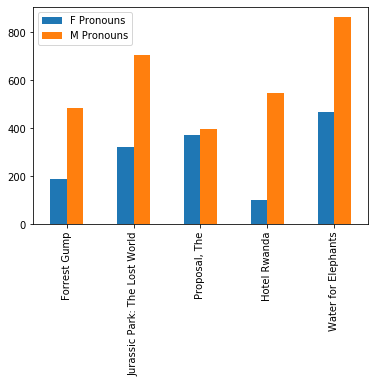

In [13]:
movies_list = []

for i in range(5):
    rand = random.randint(0,len(movie_dictionary))
    movies_list.append(movie_title_list_sub[rand].find("a").text)

create_movie_bar(movies_list)

We can also generate some summary statistics for all of the scripts in our sample.

Mean number of female pronouns per script: 265.6281407035176
Mean number of male pronouns per script: 573.4070351758794
Median number of female pronouns per script: 226.0
Median number of male pronouns per script: 584.0
Standard deviation for number of female pronouns per script: 220.06838333916903
Standard deviation of male pronouns per script: 290.42899330520794


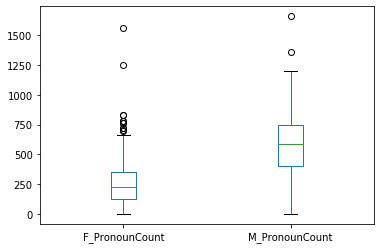

In [14]:
pronouns_frame.boxplot(grid=False)

print("Mean number of female pronouns per script: "+str(pronouns_frame.mean()[0]))
print("Mean number of male pronouns per script: "+str(pronouns_frame.mean()[1]))
print("Median number of female pronouns per script: "+str(pronouns_frame.median()[0]))
print("Median number of male pronouns per script: "+str(pronouns_frame.median()[1]))
print("Standard deviation for number of female pronouns per script: "+str(pronouns_frame.std()[0]))
print("Standard deviation of male pronouns per script: "+str(pronouns_frame.std()[1]))


Now clearly simply examining how many male and female pronouns there are in the script is not enough to see which pass the Bechdel test. However, it does go some way to demonstrating the continuing lack of prevalence of female characters in most films.